
# Restricted Boltzmann Machine features for digit classification

For greyscale image data where pixel values can be interpreted as degrees of
blackness on a white background, like handwritten digit recognition, the
Bernoulli Restricted Boltzmann machine model (:class:`BernoulliRBM
<sklearn.neural_network.BernoulliRBM>`) can perform effective non-linear
feature extraction.


In [ ]:
# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

## Generate data

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data with
linear shifts of 1 pixel in each direction.



In [1]:
import numpy as np
from scipy.ndimage import convolve

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale


def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Models definition

We build a classification pipeline with a BernoulliRBM feature extractor and
a :class:`LogisticRegression <sklearn.linear_model.LogisticRegression>`
classifier.



In [2]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

## Training

The hyperparameters of the entire model (learning rate, hidden layer size,
regularization) were optimized by grid search, but the search is not
reproduced here because of runtime constraints.



In [3]:
from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.06s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.05s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.74, time = 0.05s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.92, time = 0.05s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.48, time = 0.05s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.01, time = 0.05s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.90, time = 0.05s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.66, time = 0.05s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.37, time = 0.05s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.27, time = 0.05s


LogisticRegression(C=100.0, solver='newton-cg', tol=1)

## Evaluation



In [4]:
from sklearn import metrics

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       174
           1       0.00      0.00      0.00       184
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00       194
           4       0.00      0.00      0.00       186
           5       0.00      0.00      0.00       181
           6       0.00      0.00      0.00       207
           7       0.00      0.00      0.00       154
           8       0.00      0.00      0.00       182
           9       0.00      0.00      0.00       169

    accuracy                           0.10      1797
   macro avg       0.01      0.10      0.02      1797
weighted avg       0.01      0.10      0.02      1797




/Users/orangecloud/Desktop/PROJECTS/MY_PUBLICATIONS/NOTEBOOKS/VISUALIZE_DATA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/orangecloud/Desktop/PROJECTS/MY_PUBLICATIONS/NOTEBOOKS/VISUALIZE_DATA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/orangecloud/Desktop/PROJECTS/MY_PUBLICATIONS/NOTEBOOKS/VISUALIZE_DATA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [5]:
Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       174
           1       0.00      0.00      0.00       184
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00       194
           4       0.00      0.00      0.00       186
           5       0.00      0.00      0.00       181
           6       0.00      0.00      0.00       207
           7       0.00      0.00      0.00       154
           8       0.00      0.00      0.00       182
           9       0.00      0.00      0.00       169

    accuracy                           0.10      1797
   macro avg       0.01      0.10      0.02      1797
weighted avg       0.01      0.10      0.02      1797




/Users/orangecloud/Desktop/PROJECTS/MY_PUBLICATIONS/NOTEBOOKS/VISUALIZE_DATA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/orangecloud/Desktop/PROJECTS/MY_PUBLICATIONS/NOTEBOOKS/VISUALIZE_DATA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/orangecloud/Desktop/PROJECTS/MY_PUBLICATIONS/NOTEBOOKS/VISUALIZE_DATA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

The features extracted by the BernoulliRBM help improve the classification
accuracy with respect to the logistic regression on raw pixels.



## Plotting



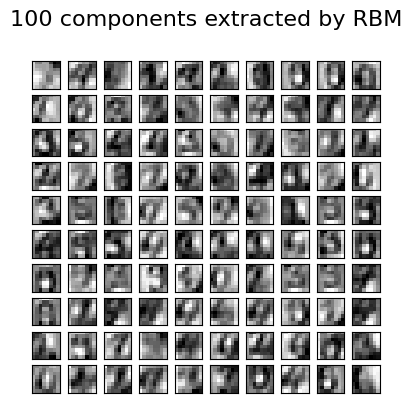

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()